In [1]:
from netgen.occ import *
from ngsolve import *
from netgen.meshing import IdentificationType
from MS_helper_functions import *
from netgen.webgui import Draw as DrawGeo
from ngsolve.webgui import Draw

import matplotlib.pyplot as plt
%matplotlib widget
plt.ioff()

from myPackage import evalOnLine
import matplotlib.pyplot as plt

from meshGen import mesh2DLaminates

In [2]:
lambda1 = 1
lambda2 = 1000

order0 = 2

In [3]:
D = 0.04
d = 0.02

ff = 0.7


numSheets = 4

maxh_edges = d/numSheets*1/2 * 0.1







## 2. Only Rough
### 2.1. Reference Solution Only Rough

In [4]:
cMeshRef = mesh2DLaminates(D, d, ff, numSheets, multiscale=False, onlyRough=True, maxh_edges=maxh_edges, fullProblemX=True, rotated=True, modelHalfAir=True, quad_dominated=False)
meshRef = cMeshRef.mesh
print("Boundaries", set(meshRef.GetBoundaries()))
print("Materials", set(meshRef.GetMaterials()))
Draw(meshRef.ngmesh)

Boundaries {'left', 'top', 'itop', 'default', 'iright', 'bottom', 'ibottom', 'right', 'ileft'}
Materials {'inner', 'outer', 'insulation'}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'mesh_dim': 2, 'mesh_cent…

BaseWebGuiScene

In [5]:
lam = meshRef.MaterialCF({"inner":lambda2, "outer":lambda1, "insulation":lambda1, "gap":lambda1, "multiscale":lambda2})
def calcRef():
    fes = H1(meshRef, order=order0, dirichlet="left|right")

    u,v = fes.TnT()
    sol = GridFunction(fes)

    a = BilinearForm(fes, symmetric=True)
    f = LinearForm(fes)

    a += lam * grad(u) * grad(v) * dx

    prec = Preconditioner(a, "direct")


    sol.Set(1 * x/Norm(x), BND)
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=10)
    
    
    energy =  Integrate( InnerProduct(lam * grad(sol), grad(sol)), meshRef, definedon=meshRef.Materials("inner|insulation"))
    
    return sol, energy

sol_ref, energy_ref = calcRef()


CG iteration 1, residual = 3.040552338850532     
CG iteration 2, residual = 1.6206338924999356e-14     


In [6]:


print(f"energy:\t{energy_ref}")
Draw(sol_ref, settings={"Objects":{"Wireframe":True}, "deformation": 0.01})
Draw( Norm(-grad(sol_ref)), meshRef, settings={"Objects":{"Wireframe":True}, "deformation": False})


energy:	0.02196443398840796


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Tru…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Tru…

BaseWebGuiScene

### 2.2 Multiscale only Rough

In [ ]:
import cempy as cp
modelHalfAir=True
cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=modelHalfAir, domainNameHalfAir="multiscale", onlyRough=True,  maxh_edges=maxh_edges, rotated=True, modelGap=True)
# cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=modelHalfAir, domainNameHalfAir="smoothFrame", onlySmooth=onlySmooth)
meshMS = cMeshMS.mesh
print(meshMS.GetMaterials())
Draw(meshMS.ngmesh)


# from myPackage import drawBndAll
# drawBndAll(meshMS, drawFunc=Draw, block=False)


In [8]:
cl_Phi.numSheets = numSheets
cl_Phi.dFe = cMeshMS.dFe
cl_Phi.d0 = cMeshMS.d0
cl_Phi.mesh = meshMS

cl_Phi.modelHalfAir = modelHalfAir
cl_Phi.orientation = 1


def calcMultiscale(useGradients=True, drawPhis=True):

    # microshape functions
    orderPhi = [
            cl_Phi(2, fes_order=2, material="multiscale|gap", dirichlet="left|right", useGradients=True, inAir=False, modelHalfAir=True), 
            cl_Phi(2, fes_order=2, material="multiscale|gap", dirichlet="left|right", useGradients=True, inIron=False, modelHalfAir=True), 


            # cl_Phi(2, fes_order=1, material="multiscale|gap", dirichlet="left|right", useGradients=True, inAir=True, modelHalfAir=True, phiFunction=cp.phiFunctions.Bubbles_cont, dzPhiFunction=cp.phiFunctions.dxBubbles_cont), 



            # cl_Phi(4, fes_order=1, material="multiscale|gap", dirichlet="left|right", useGradients=True, inAir=False, modelHalfAir=True), 
            # cl_Phi(4, fes_order=1, material="multiscale|gap", dirichlet="left|right", useGradients=True, inIron=False, modelHalfAir=True), 
        ]

    if drawPhis:
        cl_Phi.plotEvaluated(orderPhi, nFig=1)

    VSpace = []
    # u0 
    VSpace.append(H1(meshMS, order=order0, dirichlet="left|right")) 
        
    # ui * phi i
    for phi_i in orderPhi: 
        VSpace.append(H1(meshMS, order=phi_i.fes_oder, definedon=meshMS.Materials(phi_i.material), dirichlet=phi_i.dirichlet))
    VSpace = FESpace(VSpace)


    # multiscale container
    ansatz = ""
    sol = GridFunction(VSpace, "sol")
       

    cl_gradgradMS = gradgradMS(orderPhi, sol, addPhi0Outer=True)

    a = BilinearForm(VSpace, symmetric=True)
    f = LinearForm(VSpace)

    # a += lambda1  * grad(cl_gradgradMS.trials[0]) * grad(cl_gradgradMS.tests[0]) * dx("outer")
    a += getIntegrand4BFI(cl_gradgradMS.gradu, cl_gradgradMS.gradv, lambda2, lambda1, force_full_Phi=True, modelHalfAir=False) * dx("multiscale")
    a += getIntegrand4BFI(cl_gradgradMS.gradu, cl_gradgradMS.gradv, lambda1, lambda1, force_full_Phi=True, modelHalfAir=False) * dx("gap")


    # h = specialcf.mesh_size
    # um = sum([cl_gradgradMS.u[i][0] * cl_gradgradMS.u[i][1] for i in range(len(cl_gradgradMS.u))])
    # vm = sum([cl_gradgradMS.v[i][0] * cl_gradgradMS.v[i][1] for i in range(len(cl_gradgradMS.v))])
    # if True:
    #     # a += 4*order0**2/h * (um - cl_gradgradMS.trials[0])* (vm - cl_gradgradMS.tests[0]) * ds("ileft|iright", skeleton=True)
    #     a += 4*order0**2/h * (um - cl_gradgradMS.trials[0])* (vm - cl_gradgradMS.tests[0]) * ds("ileft_outer|iright_outer")
    


    prec = Preconditioner(a,type="direct") 


    # dirichlet boundary values
    sol.components[0].Set(1 * x/Norm(x), BND)
    
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=10)

    energy =  Integrate(getIntegrand4BFI(cl_gradgradMS.gradsol_pack, cl_gradgradMS.gradsol_pack, lambda2, lambda1), meshMS, 
                                                    definedon=meshMS.Materials("multiscale"))
    
    return sol, cl_gradgradMS.sol_pack, cl_gradgradMS.sol_comp, cl_gradgradMS.gradsol_comp, energy, cl_gradgradMS

    

sol_MS, sol_pack_MS, sol_comp_MS, H_comp, energy_MS, cl_gradgradMS = calcMultiscale(False, drawPhis=True)
print(energy_MS)
print(Integrate(Norm(sum(sol_comp_MS) - sol_ref), meshRef))


: 

In [ ]:
print(f"energy:\t{energy_MS}")
Draw(sum(sol_comp_MS), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False})
Draw( Norm(sum(H_comp))
, meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False})

energy:	0.019176701565573384


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

### 1.3 Comparison 

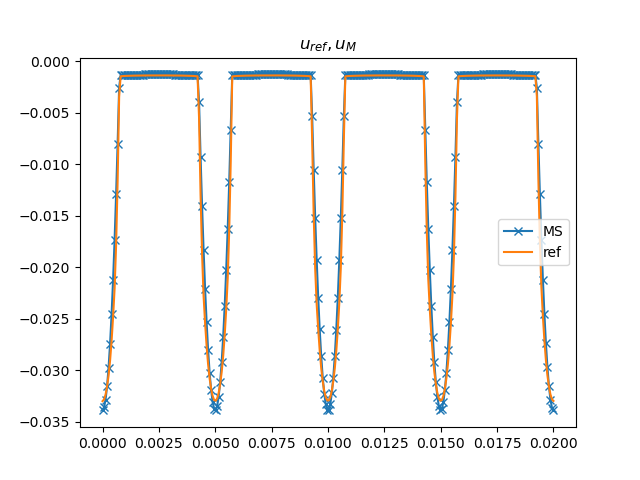

In [ ]:

start = -d/2*1.01
end = -d/2*0.9

# start = d/2*0.95
# end = d/2*1.02


plt.figure(2)
start = -d/2
end = d/2




evalOnLine(sum(sol_comp_MS) , meshRef, [-d/2, start, 0], [-d/2, end, 0], plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=300);
evalOnLine(sol_ref , meshRef, [-d/2, start, 0], [-d/2, end, 0], plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 300, title=r"$u_{ref}, u_{M}$");


plt.legend()
plt.show()

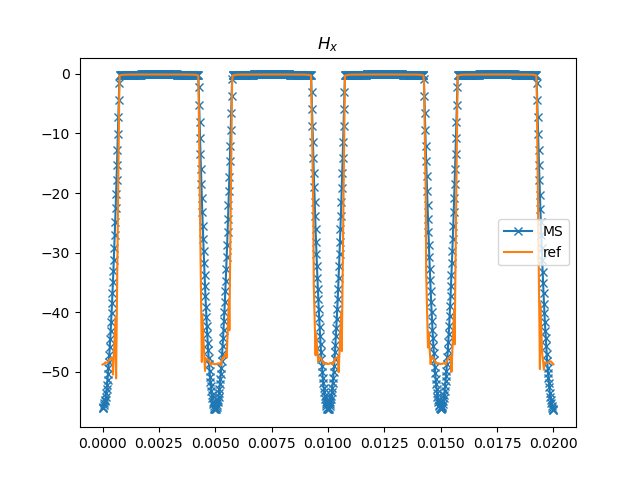

In [ ]:
start = -d/2
end = d/2

plt.figure(3)
evalOnLine(sum(H_comp)[0] , meshRef, [-d/2*0.99, start, 0], [-d/2*0.99, end, 0], plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
evalOnLine(-grad(sol_ref)[0] , meshRef, [-d/2*0.99, start, 0], [-d/2*0.99, end, 0], plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$H_x$");



plt.legend()
plt.show()

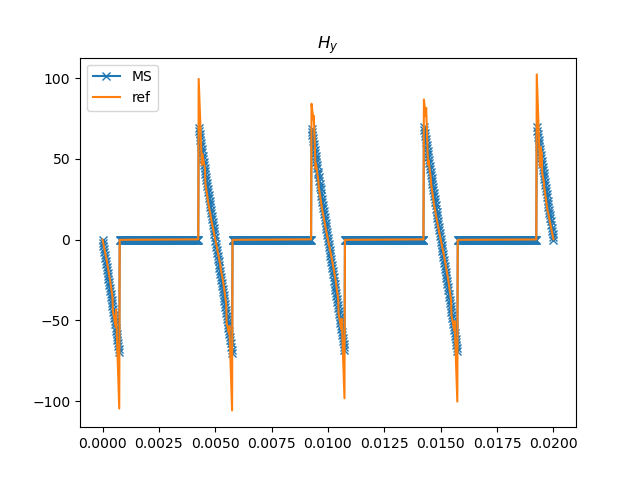

In [ ]:
start = -d/2
end = d/2


plt.figure(4)
evalOnLine(sum(H_comp)[1] , meshRef, [-d/2*0.99, start, 0], [-d/2*0.99, end, 0], plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
evalOnLine(-grad(sol_ref)[1] , meshRef, [-d/2*0.99, start, 0], [-d/2*0.99, end, 0], plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$H_y$");


plt.legend()
plt.show()

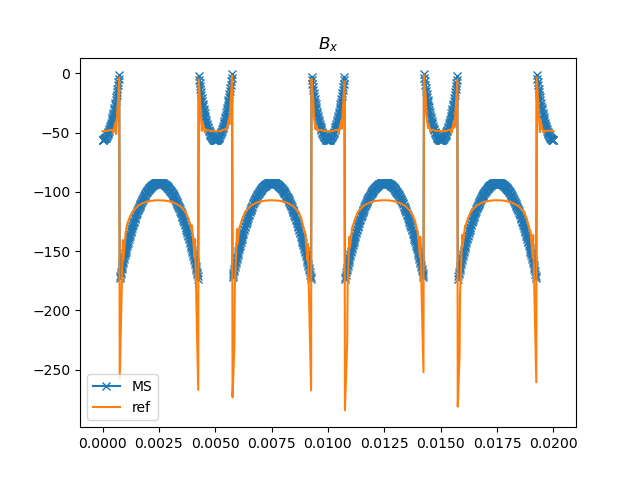

In [ ]:
start = -d/2
end = d/2


plt.figure(5)
evalOnLine(lam * sum(H_comp)[0] , meshRef, [-d/2*0.99, start, 0], [-d/2*0.99, end, 0], plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
evalOnLine(-lam * grad(sol_ref)[0] , meshRef, [-d/2*0.99, start, 0], [-d/2*0.99, end, 0], plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$B_x$");

plt.legend()
plt.show()

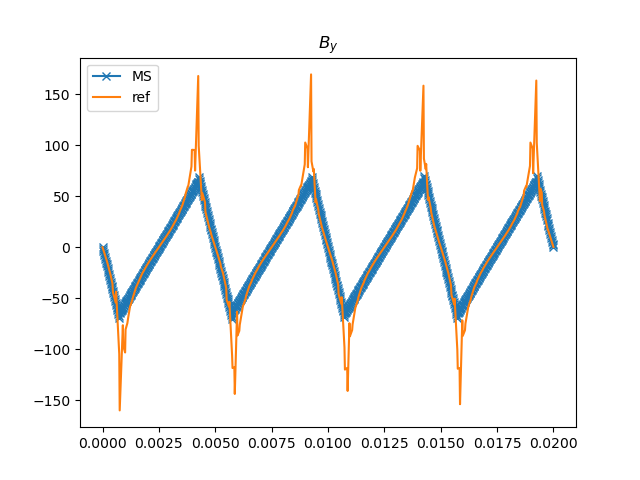

In [ ]:
start = -d/2
end = d/2

plt.figure(6)
evalOnLine(lam * sum(H_comp)[1] , meshRef, [-d/2*0.99, start, 0], [-d/2*0.99, end, 0], plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
evalOnLine(-lam * grad(sol_ref)[1] , meshRef, [-d/2*0.99, start, 0], [-d/2*0.99, end, 0], plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$B_y$");

plt.legend()
plt.show()

In [ ]:
print("Norm soll diff", Integrate(Norm(sum(sol_comp_MS) - sol_ref), meshRef))
print("diff energy", energy_MS, energy_ref, energy_MS - energy_ref)




Norm soll diff 3.66755087196393e-07
diff energy 0.019176701565573384 0.02196443398840796 -0.0027877324228345775


In [ ]:
print(f"energy:\t{energy_MS}")
Draw(IfPos(y, sol_ref, sum(sol_comp_MS)), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False})


energy:	0.019176701565573384


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

In [ ]:
Draw(IfPos(y, -grad(sol_ref), sum(H_comp))[0], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False})

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

In [ ]:
Draw(lam * IfPos(y, -grad(sol_ref), sum(H_comp))[0], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False},min = -200, max=200)
Draw(lam * IfPos(y, -grad(sol_ref), sum(H_comp))[1], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False},min = -20, max=20)
lamMS = IfPos(cl_Phi(0, 0, inIron=False, material="multiscale").phi, lambda1, lambda2)

# Draw(lamMS * IfPos(y, -grad(sol_ref), sum(H_comp))[0], meshMS, settings={"Objects":{"Wireframe":False}, "deformation": False},min = -200, max=200)
# Draw(lamMS * IfPos(y, -grad(sol_ref), sum(H_comp))[1], meshMS, settings={"Objects":{"Wireframe":False}, "deformation": False},min = -20, max=20)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

In [ ]:

import cempy as cp
o = cl_Phi(2, fes_order=0, material="multiscale", phiFunction=cp.phiFunctions.specialLobatto, dzPhiFunction=cp.phiFunctions.dxspecialLobatto)

In [ ]:
Draw(lam, meshRef)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene